In [1]:
import numpy as np
import torch
from torch import nn
import os, random, math
from tqdm import tqdm
import matplotlib.pyplot as plt
from lstm_class import MyLSTM

In [2]:
# CONSTANTS:
# for loading encoder and lstm:
LOAD_PATH_ENC = "checkpoints/encoder/"
ENC_NAME = "pretty_decent_encoder"
LOAD_PATH_LSTM = "checkpoints/lstm/"
LSTM_NAME = "trained_on_60000_paths"

# for loading dataset:
DATASET = 'random_20_density/'
MAP_SHAPE = (64,64)
NUM_TRAIN_PATHS = 10
NUM_EVAL_PATHS = 10
NUM_GENERATED_POINTS = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.maps_and_paths = []

        num_maps = 0
        for directory in tqdm(os.listdir(gen_dir)):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)
            sequence = []

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

            # add map to sequence array:
            sequence.append(torch.tensor(self.map))

            path_dir = f"{dir_path}/paths/"
            num_paths = 0
            for filename in os.listdir(path_dir):
                num_paths += 1
                with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                    path_points_list = [] # a list to hold each point in a path
                    self.flat_path = np.loadtxt(f) # load in the flat path from file
                    self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                    for point in self.path:
                        x = point[0]
                        y = point[1]
                        this_point = [x, y]
                        path_points_list.append(this_point)
                        
                sequence.append(torch.tensor(path_points_list, dtype=torch.float)[:, :])
                
            self.maps_and_paths.append(sequence)

            if num_maps == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        return path

    def __len__(self):
        return len(self.maps_and_paths)

    def __getitem__(self, idx):
        x = self.maps_and_paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [4]:
# a function which takes a list of a paths' x and y coords (that include the start and goal points), a map array, and a check distance value
# returns 1 if the path does NOT intersect with an obstacle, and 0 if the path does intersect with an obstacle
def check_if_avoids_obstacles(xs, ys, map, check_dis=0.5):

    # create obstacle_coords array:
    obstacle_coords = torch.fliplr(torch.nonzero(torch.tensor(map))).tolist()

    # check if any points are on an obstacle or if any paths connecting points crosses an obstacle:
    radius_of_obs = 0.5

    for idx in range(len(xs)):
        if idx == len(xs)-1:            # checking final point
            if not check_btw_points([xs[idx],ys[idx]], [xs[idx],ys[idx]], check_dis, obstacle_coords, radius_of_obs):
                # print("Path intersects obstacles.")
                return 0
        else:                           # checking all other points
            if not check_btw_points([xs[idx],ys[idx]], [xs[idx+1],ys[idx+1]], check_dis, obstacle_coords, radius_of_obs):
                # print("Path intersects obstacles.")
                return 0

    return 1 # if none of the prev conditions are met, return 1 (path does not cross an obstacle)

def check_btw_points(p1, p2, step, obstacle_coords, radius_of_obs, test=False):
    dis_btw_points = calc_distance(p1,p2)
    
    num_points_to_check = dis_btw_points/step
    if num_points_to_check == 0:
        num_points_to_check = 1

    if p2[0]-p1[0] != 0:            # if there is a difference in the x-axis
        
        coord_step = (p2[0]-p1[0])/num_points_to_check
        m,b = make_eq(p1, p2)

        for x in np.arange(p1[0], p2[0], coord_step):
            y = m*x + b

            if not detailed_check([x,y], obstacle_coords, radius_of_obs):
                return 0
    
    elif p2[1]-p1[1] != 0:          # if there is a difference in the y-axis (i.e. path with undefined slope)
        
        coord_step = (p2[1]-p1[1])/num_points_to_check

        for y in np.arange(p1[1], p2[1], coord_step):
            x = p1[0]

            if not detailed_check([x,y], obstacle_coords, radius_of_obs):
                return 0

    else:                           # if there is no difference in either x or y axises (i.e. the same point)
        if not detailed_check(p1, obstacle_coords, radius_of_obs):
            return 0

    return 1

def detailed_check(point, obstacle_coords, radius_of_obs):
    max_obstacle_dis = math.sqrt(radius_of_obs**2 + radius_of_obs**2)

    for ob_coord in obstacle_coords:
        dis = calc_distance(point, ob_coord)

        if (dis <= max_obstacle_dis):
            # calculate angle btw this point and obstacle point
            theta = math.acos(abs(point[0]-ob_coord[0])/dis)
            # calculate length of hypotenuse
            hypot = radius_of_obs/math.cos(theta)
            # if hypotenuse >= dis --> this point intersects with an obstacle
            if hypot >= dis:
                return 0
    return 1

def calc_distance(p1,p2):
    return math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)

def make_eq(p1, p2):
    m = (p2[1]-p1[1])/(p2[0]-p1[0])
    b = p1[1]-(m*p1[0])
    return m, b


In [5]:
# DEFINE ENCODER STRUCTURE:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [6]:
# CREATE ENCODER INSTANCE:
encoder = Encoder()

# CREATE LSTM INSTANCE:
rnn = MyLSTM(device=device)

In [7]:
# LOAD ENCODER:
checkpoint = torch.load(f'{LOAD_PATH_ENC}{ENC_NAME}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])
encoder.to(device)
encoder.eval()

# LOAD LSTM:
checkpoint = torch.load(f'{LOAD_PATH_LSTM}{LSTM_NAME}.tar')
rnn.load_state_dict(checkpoint['model_state_dict'])
rnn.to(device)
rnn.eval()

MyLSTM(
  (lstm_map): LSTMCell(128, 120)
  (lstm_points): LSTMCell(4, 120)
  (lstm1): LSTMCell(240, 120)
  (fc): Linear(in_features=120, out_features=2, bias=True)
)

In [8]:
# LOAD PATHS:
train_dataset = PathsDataset(gen_dir = f"./env/{DATASET}/train", shape = MAP_SHAPE, transform=None, device=device, stop_after=1000)
eval_dataset = PathsDataset(gen_dir = f"./env/{DATASET}/eval", shape = MAP_SHAPE, transform=None, device=device, stop_after=1000)
train_len = len(train_dataset)
eval_len = len(eval_dataset)

100%|█████████▉| 999/1000 [00:14<00:00, 69.86it/s]


Done!


100%|██████████| 10/10 [00:00<00:00, 71.80it/s]

Done!


In [9]:
# GENERATING LSTM PATHS FROM TRAIN DATA:

generated_train_paths = []
random_train_vals = []
valid_train_paths = 0

for i in range(NUM_TRAIN_PATHS):
    # choose random map:
    map_num = random.randint(0, train_len-1)
    map = train_dataset[map_num][0].to(device)
    encoded_map = encoder(map.unsqueeze(0).unsqueeze(0))

    # choose random path:
    path_num = random.randint(1, len(train_dataset[map_num])-1)
    path = train_dataset[map_num][path_num]

    # generate lstm path:
    start_point = path[0].to(device)
    goal_point = path[len(path)-1].to(device)
    generated_pts = []
    with torch.no_grad():
        # add start point:
        generated_pts.append(start_point.cpu().detach().numpy().tolist())
        prev_pred = start_point

        # predict and add other points:
        for i in range(NUM_GENERATED_POINTS):
            pred = rnn(goal_point, prev_pred, encoded_map).squeeze()
            prev_pred = pred
            generated_pts.append(pred.cpu().detach().numpy().tolist())

    generated_train_paths.append(generated_pts)
    random_train_vals.append([map_num, path_num])

    # checking if valid path:
    xs = []
    ys = []

    for x,y in generated_pts:
        xs.append(x)
        ys.append(y)

    valid_train_paths += check_if_avoids_obstacles(xs, ys, map.cpu().detach().numpy(), check_dis=0.5)

Percentage of successful paths: 60.0%


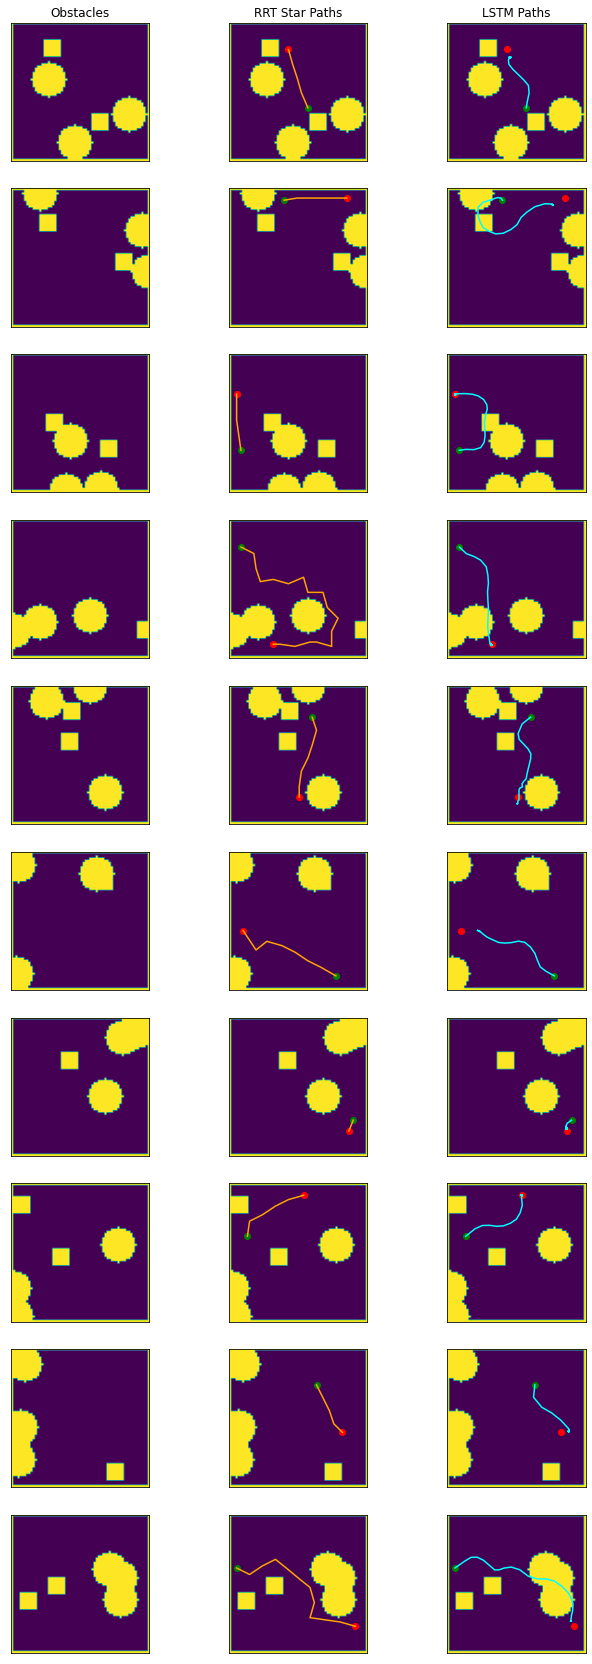

In [10]:
# CREATING FIGURE FOR TRAIN DATA:

print(f"Percentage of successful paths: {valid_train_paths/NUM_TRAIN_PATHS*100}%")

fig = plt.figure(figsize=(15,30))
fig.set_facecolor('white')

col_title = True
for i in range(NUM_TRAIN_PATHS):

    map_idx = random_train_vals[i][0]
    path_idx = random_train_vals[i][1]

    map = train_dataset[map_idx][0]
    start_point = train_dataset[map_idx][path_idx][0]
    goal_point = train_dataset[map_idx][path_idx][len(train_dataset[map_idx][path_idx])-1]

    xs = []
    ys = []
    for x,y in generated_train_paths[i]:
        xs.append(x)
        ys.append(y)

    sub = fig.add_subplot(NUM_TRAIN_PATHS,4,i*4+1)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    if col_title:
        plt.title('Obstacles')

    sub = fig.add_subplot(NUM_TRAIN_PATHS,4,i*4+2)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    # plot truth path
    plt.plot(train_dataset[map_idx][path_idx][:,0], train_dataset[map_idx][path_idx][:,1], color='orange')
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('RRT Star Paths')

    sub = fig.add_subplot(NUM_TRAIN_PATHS,4,i*4+3)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='aqua', label = "predicted")
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('LSTM Paths')

    col_title = False

plt.savefig("train_output.png", facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()

In [11]:
# GENERATING LSTM PATHS FROM EVAL DATA:

generated_eval_paths = []
random_eval_vals = []
valid_eval_paths = 0

for i in range(NUM_EVAL_PATHS):
    # choose random map:
    map_num = random.randint(0, eval_len-1)
    map = eval_dataset[map_num][0].to(device)
    encoded_map = encoder(map.unsqueeze(0).unsqueeze(0))

    # choose random path:
    path_num = random.randint(1, len(eval_dataset[map_num])-1)
    path = eval_dataset[map_num][path_num]

    # generate lstm path:
    start_point = path[0].to(device)
    goal_point = path[len(path)-1].to(device)
    generated_pts = []
    with torch.no_grad():
        # add start point:
        generated_pts.append(start_point.cpu().detach().numpy().tolist())
        prev_pred = start_point

        # predict and add other points:
        for i in range(NUM_GENERATED_POINTS):
            pred = rnn(goal_point, prev_pred, encoded_map).squeeze()
            prev_pred = pred
            generated_pts.append(pred.cpu().detach().numpy().tolist())

    generated_eval_paths.append(generated_pts)
    random_eval_vals.append([map_num, path_num])

    # checking if valid path:
    xs = []
    ys = []

    for x,y in generated_pts:
        xs.append(x)
        ys.append(y)

    valid_eval_paths += check_if_avoids_obstacles(xs, ys, map.cpu().detach().numpy(), check_dis=0.5)

Percentage of successful paths: 70.0%


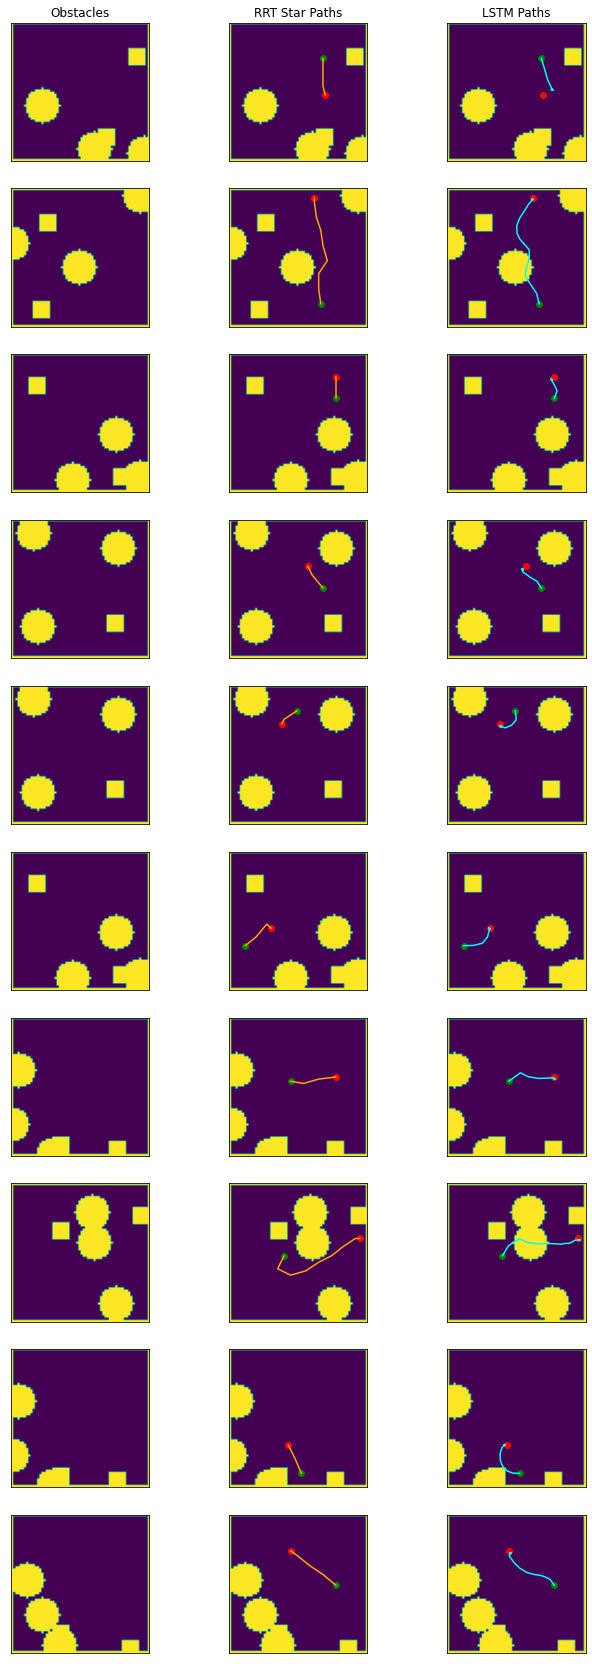

In [12]:
# CREATING FIGURE FOR EVAL DATA:

print(f"Percentage of successful paths: {valid_eval_paths/NUM_EVAL_PATHS*100}%")

fig = plt.figure(figsize=(15,30))
fig.set_facecolor('white')

col_title = True
for i in range(NUM_EVAL_PATHS):

    map_idx = random_eval_vals[i][0]
    path_idx = random_eval_vals[i][1]

    map = eval_dataset[map_idx][0]
    start_point = eval_dataset[map_idx][path_idx][0]
    goal_point = eval_dataset[map_idx][path_idx][len(eval_dataset[map_idx][path_idx])-1]

    xs = []
    ys = []
    for x,y in generated_eval_paths[i]:
        xs.append(x)
        ys.append(y)

    sub = fig.add_subplot(NUM_EVAL_PATHS,4,i*4+1)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    if col_title:
        plt.title('Obstacles')

    sub = fig.add_subplot(NUM_EVAL_PATHS,4,i*4+2)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    # plot truth path
    plt.plot(eval_dataset[map_idx][path_idx][:,0], eval_dataset[map_idx][path_idx][:,1], color='orange')
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('RRT Star Paths')

    sub = fig.add_subplot(NUM_EVAL_PATHS,4,i*4+3)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='aqua', label = "predicted")
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('LSTM Paths')

    col_title = False

plt.savefig("eval_output.png", facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()